In [1]:
import pandas as pd
import numpy as np
from numpy import load
import torch
from torch import nn
import torch.nn.functional as F
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
from scipy.linalg import norm
from PIL import Image, ImageOps
from numpy import asarray
import os

In [2]:
### import data from csv (written in data_processing)
q_array = load('q_array0.npy')
a_array = load('a_array0.npy')
N = 6000

### find number of trials
data_trials = int(a_array.shape[0])

In [3]:
xy_array = np.zeros((N,288,432))
xz_array = np.zeros((N,288,432))
# img4 = Image.open('/home/bowen/Documents/Rod_manipulation/Flexible-Tool/png_data/'+str(3)+'_xy.png')
# img4.show()

for i in range(N):
    ## on bowen's local
#     img1 = Image.open('/home/bowen/Documents/Rod_manipulation/Flexible-Tool/png_data/'+str(i)+'_xy.png')
#     img2 = Image.open('/home/bowen/Documents/Rod_manipulation/Flexible-Tool/png_data/'+str(i)+'_xz.png')
    
    ## on beast's local
    img1 = Image.open('/home/bowen/Documents/Flexible-Tool/png_data/'+str(i)+'_xy.png')
    img2 = Image.open('/home/bowen/Documents/Flexible-Tool/png_data/'+str(i)+'_xz.png')
    img1 = ImageOps.grayscale(img1)
    img2 = ImageOps.grayscale(img2)
    
    xy_array[i,:,:] = asarray(img1)
    xz_array[i,:,:] = asarray(img2)

In [4]:
print(xy_array.shape)
print(xz_array.shape)

(6000, 288, 432)
(6000, 288, 432)


In [5]:
## put two image arraies into one single array with two channels and then reshape it because of the format of pytorch
image_array = np.stack([xy_array,xz_array], axis = -1).squeeze()
image_array = np.transpose(image_array,[0,3,1,2]) ## change the axis
print(image_array.shape)

(6000, 2, 288, 432)


In [6]:
## split image data and a_array into test and train set and put them into tensor and dataloader
image_train_x = (image_array[0:int(0.8*N),:,:,:]).astype(np.float32) 
image_test_x = (image_array[int(0.8*N):N,:,:,:]).astype(np.float32) 

train_y = (a_array[0:int(0.8*N),:]).astype(np.float32)
test_y = (a_array[int(0.8*N):N,:]).astype(np.float32)

y_test_tensor = torch.from_numpy(test_y)
y_train_tensor = torch.from_numpy(train_y)

imagex_test_tensor = torch.from_numpy(image_test_x)
test_data = [(imagex_test_tensor[i],y_test_tensor[i]) for i in range(imagex_test_tensor.shape[0])]
imagex_train_tensor = torch.from_numpy(image_train_x)




In [7]:
train_dataset = torch.utils.data.TensorDataset(imagex_train_tensor, y_train_tensor)
test_dataset = torch.utils.data.TensorDataset(imagex_test_tensor, y_test_tensor)

train_loader = torch.utils.data.DataLoader(train_dataset, batch_size = 500, shuffle=True)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size = 500, shuffle=True)

for batch, (img,y) in enumerate(train_loader):
    print("batch", batch)
    print("Shape of img: ", img.shape, img.dtype)
    print("Shape of y: ", y.shape, y.dtype)
    break

batch 0
Shape of img:  torch.Size([500, 2, 288, 432]) torch.float32
Shape of y:  torch.Size([500, 6]) torch.float32


In [8]:
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()

        self.pool = nn.MaxPool2d(2)
        self.relu = nn.functional.relu

        self.conv1 = nn.Conv2d(in_channels=2, out_channels=16, kernel_size=3)
        self.conv2 = nn.Conv2d(in_channels=16, out_channels=32, kernel_size=3)
        self.conv3 = nn.Conv2d(in_channels=32, out_channels=32, kernel_size=3)
        self.conv4 = nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3)
        self.conv5 = nn.Conv2d(in_channels=64, out_channels=128, kernel_size=3)
        
        ## the input features should be the flatten version of the outchannel from the last conv2d layer
        self.linear1 = nn.Linear(9856, 4096)
        self.linear2 = nn.Linear(4096, 1024)
        self.linear3 = nn.Linear(1024, 256)
        self.linear4 = nn.Linear(256, 64)
        self.linear5 = nn.Linear(64, 32)
        self.linear6 = nn.Linear(32, 6)

    def forward(self, img):
        img_out = self.pool(self.relu(self.conv1(img)))
        img_out = self.pool(self.relu(self.conv2(img_out)))
        img_out = self.pool(self.relu(self.conv3(img_out)))
        img_out = self.pool(self.relu(self.conv4(img_out)))
        img_out = self.pool(self.relu(self.conv5(img_out)))

        img_out = nn.Flatten()(img_out)
#         print('image_out size:')
#         print(img_out.size())

        output = self.relu(self.linear1(img_out))
        output = self.relu(self.linear2(output))
        output = self.relu(self.linear3(output))
        output = self.relu(self.linear4(output))
        output = self.relu(self.linear5(output))
        output = self.linear6(output)

        return output
model = Net()
print(model)

Net(
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv1): Conv2d(2, 16, kernel_size=(3, 3), stride=(1, 1))
  (conv2): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1))
  (conv3): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1))
  (conv4): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1))
  (conv5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1))
  (linear1): Linear(in_features=9856, out_features=4096, bias=True)
  (linear2): Linear(in_features=4096, out_features=1024, bias=True)
  (linear3): Linear(in_features=1024, out_features=256, bias=True)
  (linear4): Linear(in_features=256, out_features=64, bias=True)
  (linear5): Linear(in_features=64, out_features=32, bias=True)
  (linear6): Linear(in_features=32, out_features=6, bias=True)
)


In [9]:
### loss function and optimizer for training 
loss_fn = torch.nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=1e-2)
       

In [10]:
### Functions for training
def train(dataloader, model, loss_fn, optimizer,loss_list):
    size = len(dataloader.dataset)
    model.train()
    for batch, (img,y) in enumerate(dataloader):

#         print("batch ", batch)
#         print("Shape of img: ", img.size())
#         print("Shape of q: ", q.size())
    
        # Compute prediction error
        pred = model(img)
#         print("pred", pred)
#         print("y", y)
        loss = loss_fn(pred, y)

        # Backpropagation
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        if batch % 10 == 0:
            loss, current = loss.item(), batch * 9856
            loss_list.append(loss)
        if batch % 20 == 0:
#             print('-----------')
            print(f"loss: {loss:>7f}  [{current:>5d}/{size:>5d}]")
    return loss_list

In [11]:
### function for testing the model
def test(dataloader, model,test_loss_list):
    size = len(dataloader.dataset)
    model.eval()
    test_loss, correct = 0, 0
    with torch.no_grad():
        for img, y in dataloader:
            pred = model(img)
            test_loss += loss_fn(pred, y)
    print(f"Test Error: Loss = {test_loss:>8f} \n")
    test_loss_list.append(test_loss)
    return test_loss_list

In [12]:
### Train the model
epochs = 300
loss_list=[]
test_loss_list=[]
for t in range(epochs):
    print(f"Epoch {t+1}\n-------------------------------")
    loss_list = train(train_loader, model, loss_fn, optimizer,loss_list)
#     print('finish train')
    test_loss_list = test(test_loader, model, test_loss_list)

Epoch 1
-------------------------------


/usr/local/lib/python3.8/dist-packages/torch/nn/functional.py:718: UserWarning: Named tensors and all their associated APIs are an experimental feature and subject to change. Please do not use them for anything important until they are released as stable. (Triggered internally at  /pytorch/c10/core/TensorImpl.h:1156.)
  return torch.max_pool2d(input, kernel_size, stride, padding, dilation, ceil_mode)


loss: 0.322267  [    0/ 4800]
Test Error: Loss = 518.294739 

Epoch 2
-------------------------------
loss: 172.766846  [    0/ 4800]
Test Error: Loss = 25.766640 

Epoch 3
-------------------------------
loss: 8.564888  [    0/ 4800]
Test Error: Loss = 0.641971 

Epoch 4
-------------------------------
loss: 0.210761  [    0/ 4800]
Test Error: Loss = 0.459933 

Epoch 5
-------------------------------
loss: 0.148544  [    0/ 4800]
Test Error: Loss = 0.394677 

Epoch 6
-------------------------------
loss: 0.132240  [    0/ 4800]
Test Error: Loss = 0.393291 

Epoch 7
-------------------------------
loss: 0.125592  [    0/ 4800]
Test Error: Loss = 0.390363 

Epoch 8
-------------------------------
loss: 0.125393  [    0/ 4800]
Test Error: Loss = 0.390989 

Epoch 9
-------------------------------
loss: 0.125107  [    0/ 4800]
Test Error: Loss = 0.384896 

Epoch 10
-------------------------------
loss: 0.124042  [    0/ 4800]
Test Error: Loss = 0.380357 

Epoch 11
-------------------------

Test Error: Loss = 0.201635 

Epoch 83
-------------------------------
loss: 0.067135  [    0/ 4800]
Test Error: Loss = 0.201035 

Epoch 84
-------------------------------
loss: 0.067054  [    0/ 4800]
Test Error: Loss = 0.199550 

Epoch 85
-------------------------------
loss: 0.064912  [    0/ 4800]
Test Error: Loss = 0.224783 

Epoch 86
-------------------------------
loss: 0.075507  [    0/ 4800]
Test Error: Loss = 0.212195 

Epoch 87
-------------------------------
loss: 0.069207  [    0/ 4800]
Test Error: Loss = 0.202127 

Epoch 88
-------------------------------
loss: 0.066443  [    0/ 4800]
Test Error: Loss = 0.203799 

Epoch 89
-------------------------------
loss: 0.065643  [    0/ 4800]
Test Error: Loss = 0.194588 

Epoch 90
-------------------------------
loss: 0.064248  [    0/ 4800]
Test Error: Loss = 0.191653 

Epoch 91
-------------------------------
loss: 0.062488  [    0/ 4800]
Test Error: Loss = 0.212095 

Epoch 92
-------------------------------
loss: 0.071861  [   

loss: 0.058036  [    0/ 4800]
Test Error: Loss = 0.169614 

Epoch 164
-------------------------------
loss: 0.054806  [    0/ 4800]
Test Error: Loss = 0.168848 

Epoch 165
-------------------------------
loss: 0.056491  [    0/ 4800]
Test Error: Loss = 0.169297 

Epoch 166
-------------------------------
loss: 0.055876  [    0/ 4800]
Test Error: Loss = 0.171485 

Epoch 167
-------------------------------
loss: 0.054203  [    0/ 4800]
Test Error: Loss = 0.168496 

Epoch 168
-------------------------------
loss: 0.056847  [    0/ 4800]
Test Error: Loss = 0.169426 

Epoch 169
-------------------------------
loss: 0.056686  [    0/ 4800]
Test Error: Loss = 0.169545 

Epoch 170
-------------------------------
loss: 0.056161  [    0/ 4800]
Test Error: Loss = 0.170310 

Epoch 171
-------------------------------
loss: 0.054868  [    0/ 4800]
Test Error: Loss = 0.173856 

Epoch 172
-------------------------------
loss: 0.056497  [    0/ 4800]
Test Error: Loss = 0.173354 

Epoch 173
------------

loss: 0.054827  [    0/ 4800]
Test Error: Loss = 0.173864 

Epoch 245
-------------------------------
loss: 0.055018  [    0/ 4800]
Test Error: Loss = 0.167414 

Epoch 246
-------------------------------
loss: 0.055111  [    0/ 4800]
Test Error: Loss = 0.166778 

Epoch 247
-------------------------------
loss: 0.051789  [    0/ 4800]
Test Error: Loss = 0.167631 

Epoch 248
-------------------------------
loss: 0.056766  [    0/ 4800]
Test Error: Loss = 0.169199 

Epoch 249
-------------------------------
loss: 0.056024  [    0/ 4800]
Test Error: Loss = 0.171481 

Epoch 250
-------------------------------
loss: 0.057298  [    0/ 4800]
Test Error: Loss = 0.167870 

Epoch 251
-------------------------------
loss: 0.055611  [    0/ 4800]
Test Error: Loss = 0.166861 

Epoch 252
-------------------------------
loss: 0.057182  [    0/ 4800]
Test Error: Loss = 0.166090 

Epoch 253
-------------------------------
loss: 0.055573  [    0/ 4800]
Test Error: Loss = 0.167786 

Epoch 254
------------

In [17]:
n = np.random.randint(0,int(0.2*N))
img,y = test_dataset[n]
img = torch.unsqueeze(img, 0) 
# q = torch.unsqueeze(q, 0) 
pred = model(img)
print(pred[0])
print(y_test_tensor[n])

tensor([0.3972, 0.7630, 0.4104, 0.4611, 0.5746, 0.5109],
       grad_fn=<SelectBackward>)
tensor([0.4353, 0.8144, 0.5813, 0.2449, 0.8970, 0.4188])


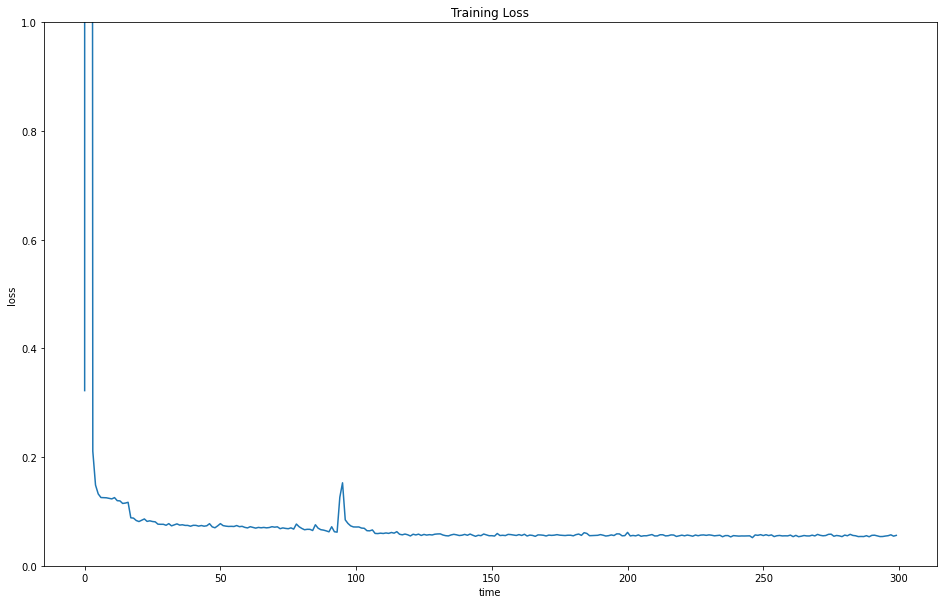

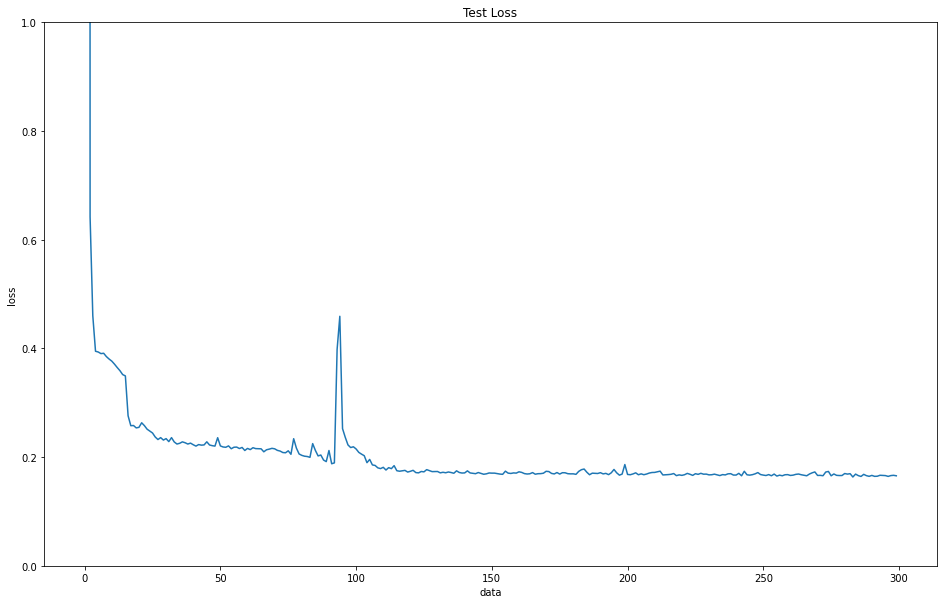

In [21]:
### Plot results
plt.figure(figsize=(16,10))
plt.plot(loss_list)
axes = plt.gca()
plt.title('Training Loss')
plt.xlabel('time')
plt.ylabel('loss')
axes.set_ylim([0,1.0])
plt.show()

plt.figure(figsize=(16,10))
plt.plot(test_loss_list)
axes = plt.gca()
plt.title('Test Loss')
plt.xlabel('data')
plt.ylabel('loss')
# axes.set_ylim([0.06,0.09])
axes.set_ylim([0,1.0])
plt.show()

In [23]:

torch.save(model.state_dict(), '/home/bowen/Documents/Flexible-Tool/models/model_6000.pth')